# Capstone Project - Sentimental Analysis on the Singapore Stock Market

### Library

In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# %cd data

In [4]:
import functions as fn, sentiment_analysis as sa, model

### Import and Data 

In [5]:
'''
Stocks are downloaded from yahoo finance from Jan 2015 to Dec 2022 for analysis 
which are in line with the period of the sentiment analysis available (later part)
The function returns the merged data and the invidual stocks. 
'''
data, es3, amzn, msft, aapl, tsla, goog = fn.read_process_stock()

In [6]:
data.head(2)

,Date,Open_amzn,High_amzn,Low_amzn,Close_amzn,Adj Close_amzn,Volume_amzn,Open_msft,High_msft,Low_msft,Close_msft,Adj Close_msft,Volume_msft,Open_aapl,High_aapl,Low_aapl,Close_aapl,Adj Close_aapl,Volume_aapl,Open_tsla,High_tsla,Low_tsla,Close_tsla,Adj Close_tsla,Volume_tsla,Open_goog,High_goog,Low_goog,Close_goog,Adj Close_goog,Volume_goog,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3
0,2015-01-02,15.6290,15.7375,15.3480,15.4260,15.4260,55664000,46.660000,47.419998,46.540001,46.759998,40.452747,27913900,27.8475,27.860001,26.837500,27.3325,24.466450,212818400,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,26.378078,26.49077,26.133251,26.168653,26.168653,28951268,3.40,3.42,3.40,3.41,2.512212,114000.0
1,2015-01-05,15.3505,15.4190,15.0425,15.1095,15.1095,55484000,46.369999,46.730000,46.250000,46.330002,40.080730,39673900,27.0725,27.162500,26.352501,26.5625,23.777189,257142000,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,26.091366,26.14472,25.582764,25.623152,25.623152,41196796,3.41,3.41,3.36,3.37,2.482742,165000.0


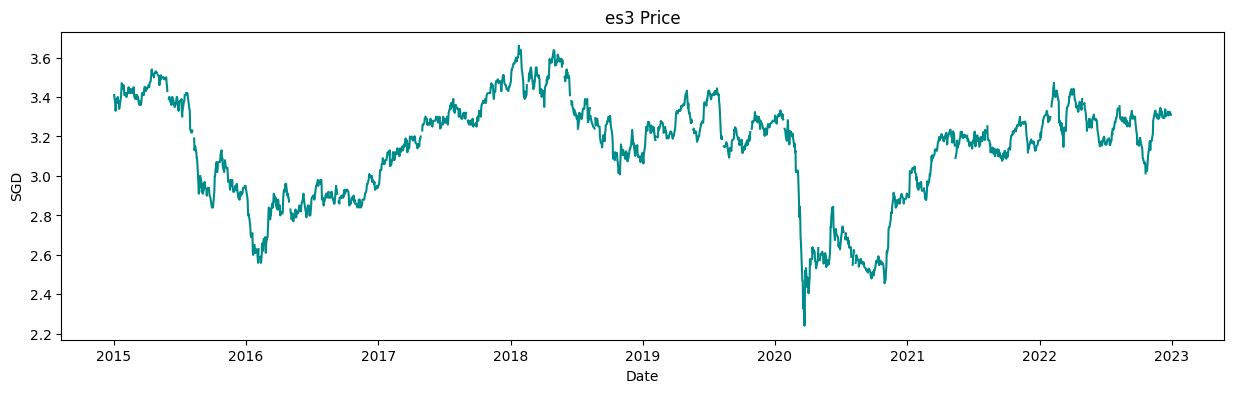

In [7]:
fn.plot_ts(data, 'es3', 'SGD')

In [8]:
data_1617 = fn.data_2016_2017(data) #obtain 2016 and 2017 data for train-test

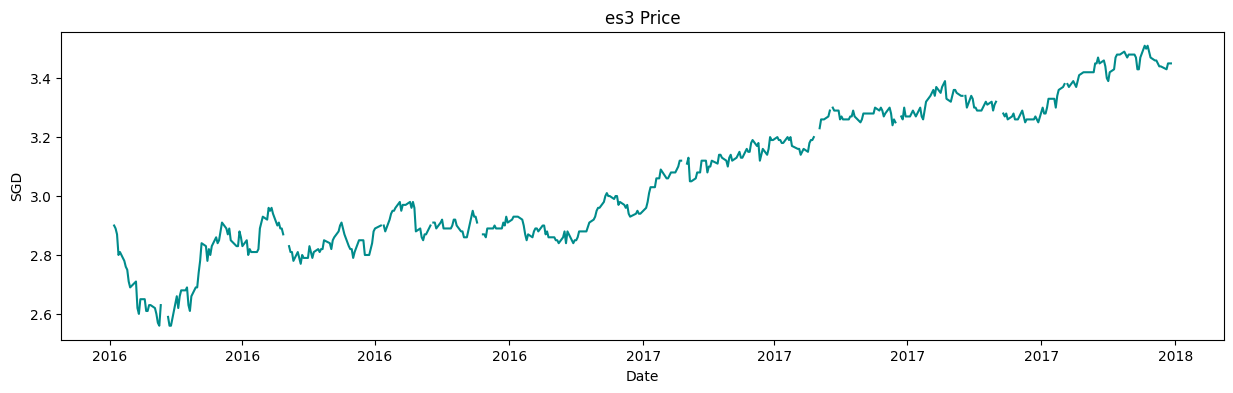

In [9]:
fn.plot_ts(data_1617, 'es3', 'SGD')

,Close_amzn,Close_msft,Close_aapl,Close_tsla,Close_goog,Close_es3
Close_amzn,1.000000,0.941533,0.926622,0.806732,0.947235,0.945309
Close_msft,0.941533,1.000000,0.967656,0.819955,0.977545,0.946874
Close_aapl,0.926622,0.967656,1.000000,0.878794,0.966207,0.959121
Close_tsla,0.806732,0.819955,0.878794,1.000000,0.862280,0.888804
Close_goog,0.947235,0.977545,0.966207,0.862280,1.000000,0.947545
Close_es3,0.945309,0.946874,0.959121,0.888804,0.947545,1.000000


<Axes: >

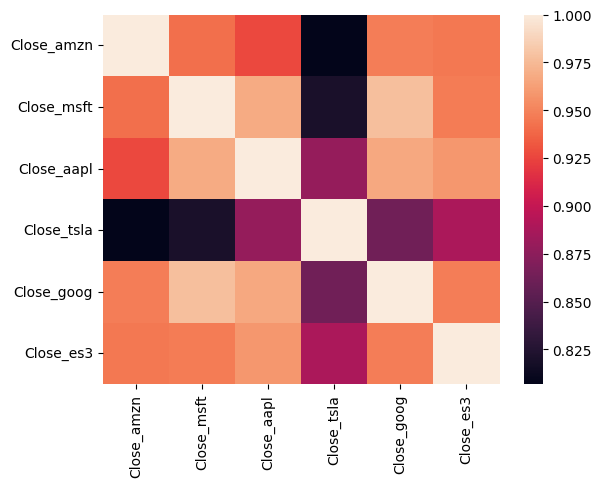

In [10]:
# get correlation between close price of the US stocks and es3 
fn.get_corr(data_1617)

From the correlation graphics, we can see that the top 3 with highest correlation to es3 are msft, goog and aapl which we will be using sentiment analysis for. The following are plots of the stocks which all demonstrate similar trends during this period of time. 

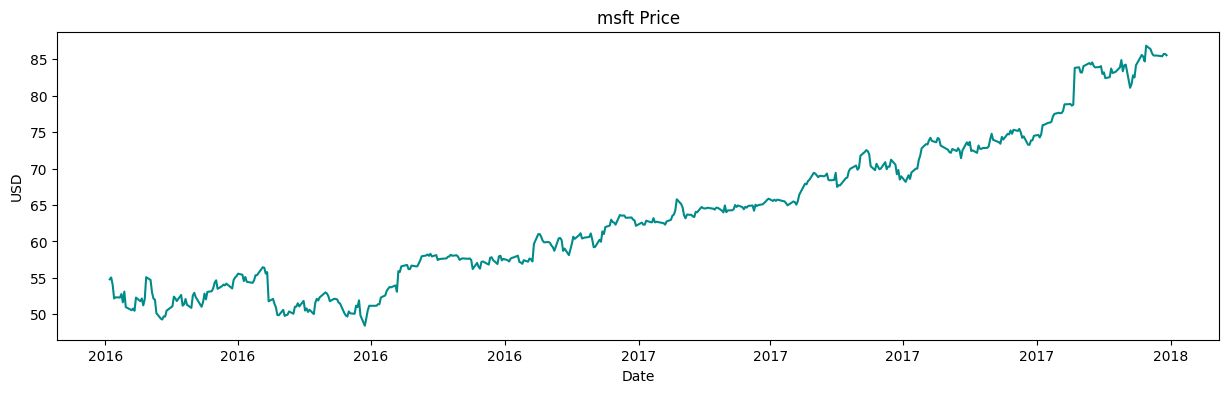

In [11]:
fn.plot_ts(data_1617, 'msft', 'USD')

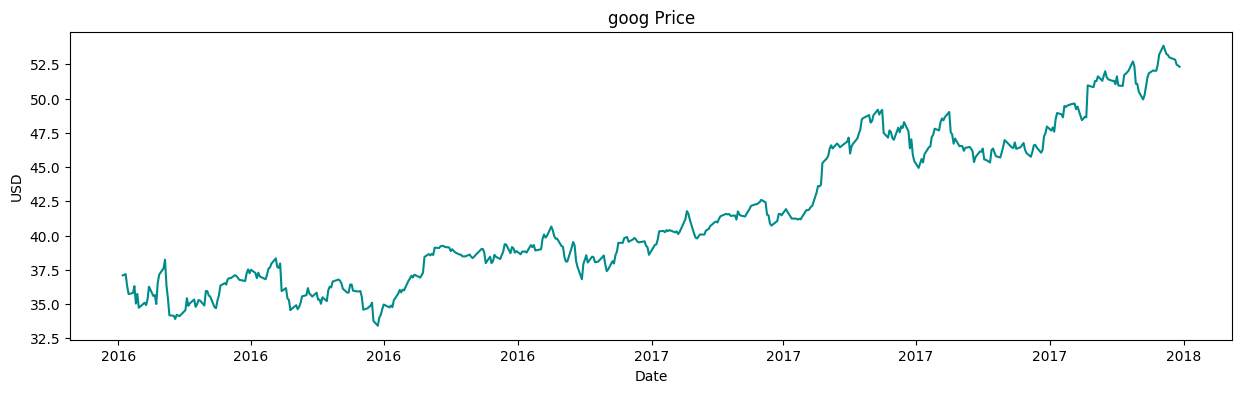

In [12]:
fn.plot_ts(data_1617, 'goog', 'USD')

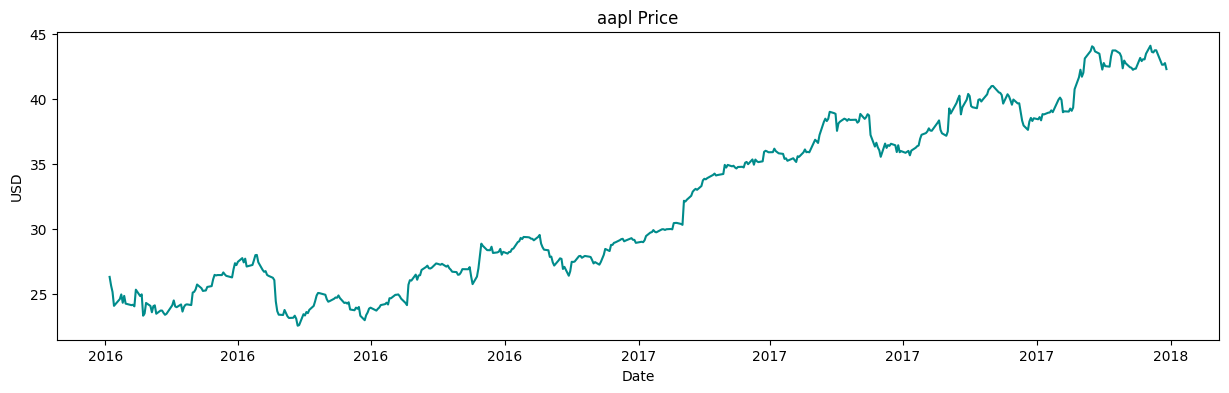

In [13]:
fn.plot_ts(data_1617, 'aapl', 'USD')

## Prepare ES3 stock-related features

In order to help the model understand the trend of the training data better and give better predictions, technical indicators listed in the following are added. 
- Moving averages (MA7 and MA20)
- Bollinger bands (lower and upper)
- MACD: subtracting the 26-period exponential moving average (EMA) from the 12-period EMA

,Date,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3,MA7,MA20,MACD,20SD,upper_band,lower_band
228,2016-01-04,2.95,2.95,2.88,2.90,2.198987,665800,2.935714,2.9195,-0.001563,0.023946,2.967392,2.871608
229,2016-01-05,2.90,2.90,2.88,2.89,2.191404,511700,2.931429,2.9175,0.000643,0.024682,2.966864,2.868136


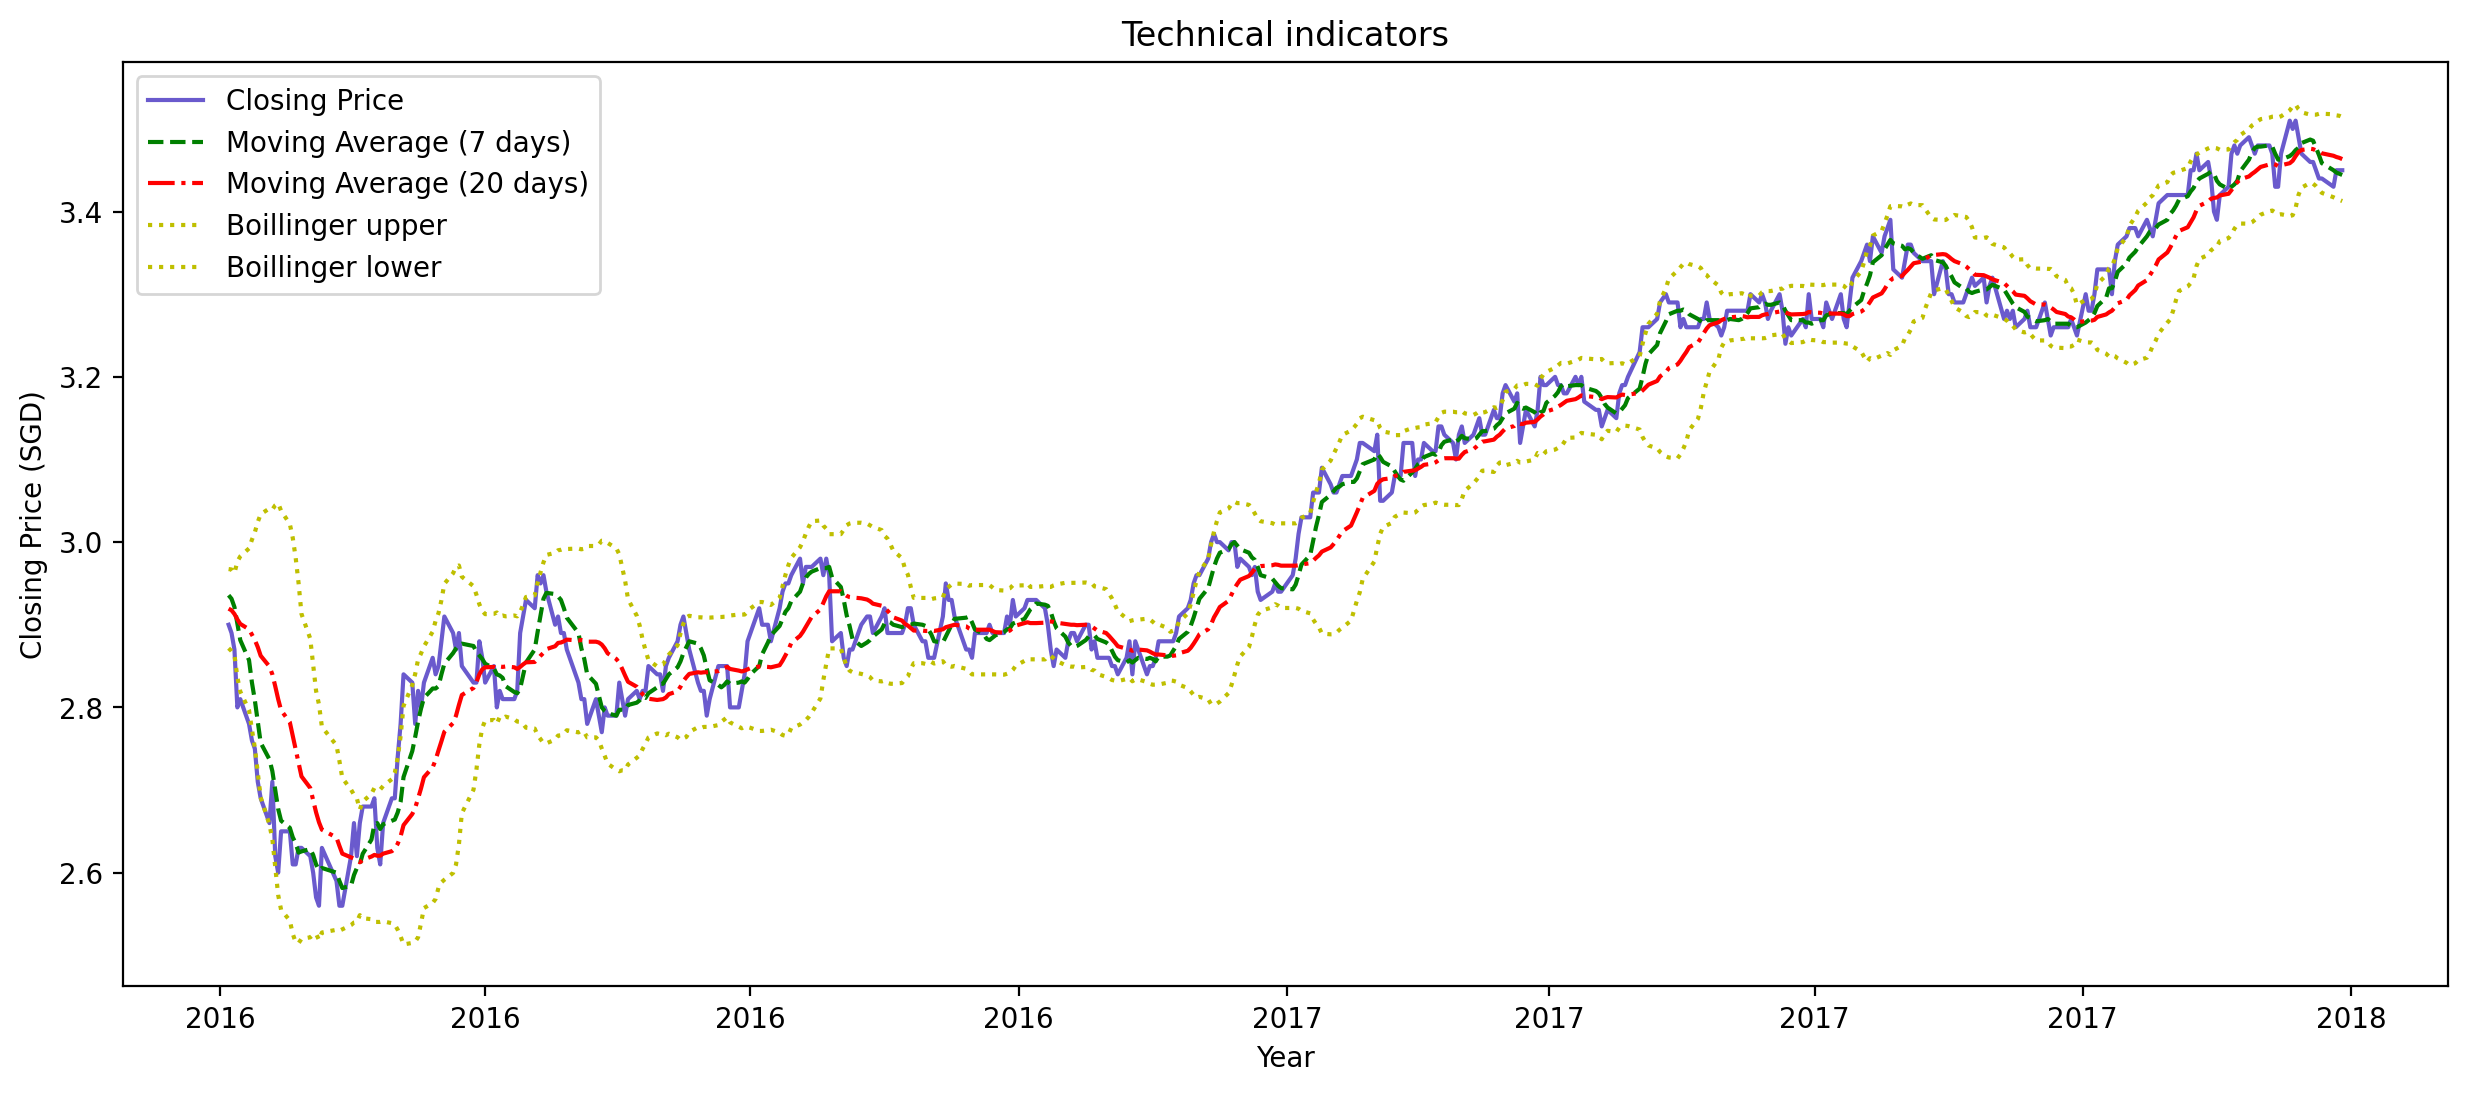

In [14]:
es3ta_1617 = fn.prep_es3_with_technical_analysis(es3)

## Prepare Sentiment Analysis (SA)

Dataset: https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020/data

In [16]:
tweet_old = pd.read_csv('Tweet.csv',engine='python',encoding='utf-8',on_bad_lines='warn')
coy_tweet = pd.read_csv('Company_Tweet.csv',engine='python',encoding='utf-8',on_bad_lines='warn')

In [17]:
tweets = sa.process_sa_data(tweet_old, coy_tweet)

There are 3717964 tweet in total.
Data Read: 


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0


,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL


From 2016 to 2017, there are 1678172 tweets.


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol
0,682712868064747520,amigobulls,1451606406,10 Reasons why $AAPL is underpriced - part 2 h...,0,0,0,2016-01-01,AAPL
1,682712975996661760,Maximum_Pain_cm,1451606432,$AMZN Max Pain = 680.00. Maturity = 12/31/2015...,0,0,0,2016-01-01,AMZN


In [18]:
tweets.body[100]

'#Nasdaq Outperforms: 3 #ETFs in Focus $ONEQ $QQEW $QQQ Also $IBB $AAPL $AMZN $MSFT $XLE $GOOGL http://goo.gl/Mgx00z'

In [19]:
sia = SentimentIntensityAnalyzer()

print('Tesla misses quarterly earnings, analyst calls downgrade, sell now')
print(sia.polarity_scores('Tesla misses quarterly earnings, analyst calls downgrade, sell now'))

Tesla misses quarterly earnings, analyst calls downgrade, sell now
{'neg': 0.192, 'neu': 0.808, 'pos': 0.0, 'compound': -0.2263}


In [20]:
print('Google earnings is not looking that bad, analyst recommends hold')
sia.polarity_scores('Google earnings is not looking that bad, analyst recommends hold')

Google earnings is not looking that bad, analyst recommends hold


{'neg': 0.0, 'neu': 0.627, 'pos': 0.373, 'compound': 0.5789}

### Augment Vocabulary for Stocks to Improve SA
We can improve the sentiment analysis scores by augmenting vocabulary meant for stock purpose. \
Example is telling VADER that positive words include 'underpriced, bullish, high profit etc.'.

In [21]:
positive_words='high profit Growth Potential Opportunity Bullish Strong Valuable Success \
Promising Profitable Win Winner Outstanding Record Earnings Breakthrough buy bull long \
support undervalued underpriced cheap upward rising trend moon rocket hold breakout call \
beat support buying holding'
negative_words='resistance squeeze cover seller Risk Loss Decline Bearish Weak Declining \
Uncertain Troubling Downturn Struggle Unstable Volatile Slump Disaster Plunge sell bear \
bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss'

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}

sia.lexicon.update(Financial_Lexicon)

print('Tesla misses quarterly earnings, analyst calls downgrade, sell now')
sia.polarity_scores('Tesla misses quarterly earnings, analyst calls downgrade, sell now')

Tesla misses quarterly earnings, analyst calls downgrade, sell now


{'neg': 0.496, 'neu': 0.504, 'pos': 0.0, 'compound': -0.7845}

In [22]:
print('Google earnings is not looking that bad, analyst recommends hold')
sia.polarity_scores('Google earnings is not looking that bad, analyst recommends hold')

Google earnings is not looking that bad, analyst recommends hold


{'neg': 0.0, 'neu': 0.418, 'pos': 0.582, 'compound': 0.8674}

In [23]:
tweets.ticker_symbol.unique()

array(['AAPL', 'AMZN', 'MSFT', 'GOOG', 'GOOGL', 'TSLA'], dtype=object)

In [24]:
tweets['ticker_symbol'] = np.where(tweets['ticker_symbol'] =='GOOGL', 'GOOG', tweets['ticker_symbol'])

In [25]:
tweets.ticker_symbol.unique()

array(['AAPL', 'AMZN', 'MSFT', 'GOOG', 'TSLA'], dtype=object)

In [ ]:
s_aapl = sa.get_sentiment(sia, tweets,'AAPL',start='2016-01-01',end='2017-12-31')
s_msft = sa.get_sentiment(sia, tweets,'MSFT',start='2016-01-01',end='2017-12-31')
s_goog = sa.get_sentiment(sia, tweets,'GOOG',start='2016-01-01',end='2017-12-31')

In [37]:
s_goog.head(2)

,date,score,label,tweet_id,body
3,2016-01-01,0.25,neutral,682713776584396801,Netflix: 2016 Outlook - Slight Chance Of Showe...
4,2016-01-01,0.25,neutral,682713776584396801,Netflix: 2016 Outlook - Slight Chance Of Showe...


In [49]:
#process the sentiment analysis scores of all 3 stocks and merge with es3 2016 2017 dataset. Also drop 20SD. 
final = sa.get_es3_sa([s_aapl, s_msft, s_goog], 
                      ['aapl_avg_score','msft_avg_score','goog_avg_score'], es3ta_1617) 

,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3,MA7,MA20,MACD,upper_band,lower_band,goog_avg_score
2016-01-04,2.95,2.95,2.88,2.90,2.198987,665800,2.935714,2.9195,-0.001563,2.967392,2.871608,0.087948
2016-01-05,2.90,2.90,2.88,2.89,2.191404,511700,2.931429,2.9175,0.000643,2.966864,2.868136,0.058207
2016-01-06,2.89,2.90,2.87,2.87,2.176239,516500,2.921429,2.9130,0.002307,2.962460,2.863540,0.076407
2016-01-07,2.87,2.87,2.80,2.80,2.123160,2925100,2.901429,2.9065,0.001248,2.976470,2.836530,0.058930
2016-01-08,2.80,2.82,2.77,2.81,2.130742,1294000,2.881429,2.9010,0.011117,2.982796,2.819204,0.116196


In [50]:
final[final.isnull().any(axis=1)]

,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3,MA7,MA20,MACD,upper_band,lower_band,goog_avg_score


In [ ]:
final.to_pickle('final.pkl')

## Build Model

In [5]:
final = pd.read_pickle('final.pkl')

In [6]:
X_scale_dataset,y_scale_dataset = model.normalize_data(final, (-1,1), "Close_es3")
X_batched, y_batched, yc = model.batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = model.split_train_test(X_batched)
y_train, y_test, = model.split_train_test(y_batched)
yc_train, yc_test, = model.split_train_test(yc)
index_train, index_test, = model.predict_index(final, X_train, 5, 1)


X shape: (497, 5, 12)
y shape: (497, 1)
yc shape: (497, 5, 1)


In [7]:
# Dataset without sentiment analysis
X_train_wo = X_train[:,:,:-3]
X_test_wo = X_test[:,:,:-3]
y_train_wo = y_train 
y_test_wo = y_test
yc_train_wo = yc_train
yc_test_wo = yc_test
index_train_wo, index_test_wo, = model.predict_index(final, X_train_wo, 5, 1)

In [8]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]
feature_size_wo = X_train_wo.shape[2] 

### MODEL WITH SENTIMENT ANALYSIS

In [60]:
learning_rate = 5e-4
epochs = 500
tf.random.set_seed(42)

g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator = model.make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = model.make_discriminator_model(X_train.shape[1])

Create directory es3 and es3_wo and TRAIN MODEL

 10%|████▏                                     | 50/500 [01:01<08:20,  1.11s/it]

epoch 50 discriminator_loss 1.3898292 generator_loss 0.6823523


 20%|████████▏                                | 100/500 [01:54<07:05,  1.06s/it]

epoch 100 discriminator_loss 1.3886949 generator_loss 0.69236326


 30%|████████████▎                            | 150/500 [02:46<06:40,  1.14s/it]

epoch 150 discriminator_loss 1.3850694 generator_loss 0.6956114


 40%|████████████████▍                        | 200/500 [03:41<05:35,  1.12s/it]

epoch 200 discriminator_loss 1.3870103 generator_loss 0.69216895


 50%|████████████████████▌                    | 250/500 [04:35<04:48,  1.15s/it]

epoch 250 discriminator_loss 1.3872248 generator_loss 0.69557875


 60%|████████████████████████▌                | 300/500 [05:29<04:00,  1.20s/it]

epoch 300 discriminator_loss 1.3888662 generator_loss 0.69124305


 70%|████████████████████████████▋            | 350/500 [06:25<02:47,  1.12s/it]

epoch 350 discriminator_loss 1.3877022 generator_loss 0.6923187


 80%|████████████████████████████████▊        | 400/500 [07:20<01:53,  1.13s/it]

epoch 400 discriminator_loss 1.3868284 generator_loss 0.6930199


 90%|████████████████████████████████████▉    | 450/500 [08:16<00:58,  1.18s/it]

epoch 450 discriminator_loss 1.3861184 generator_loss 0.69332397


100%|█████████████████████████████████████████| 500/500 [09:11<00:00,  1.10s/it]

epoch 500 discriminator_loss 1.3873789 generator_loss 0.693655


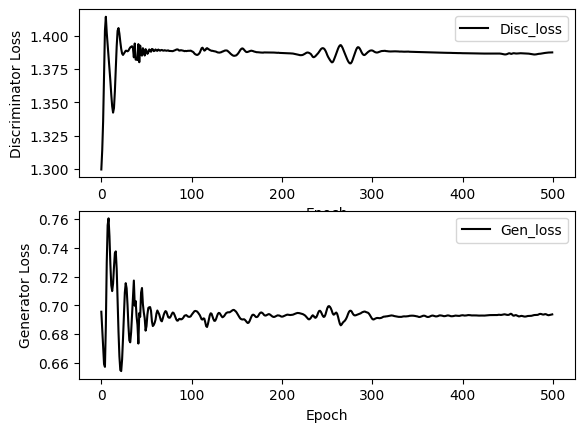

In [62]:
stock_name = 'es3'
predicted_price, real_price, RMSPE = model.train(stock_name, X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [63]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.keras', compile=False)

Test RMSE:  0.029943582635428637


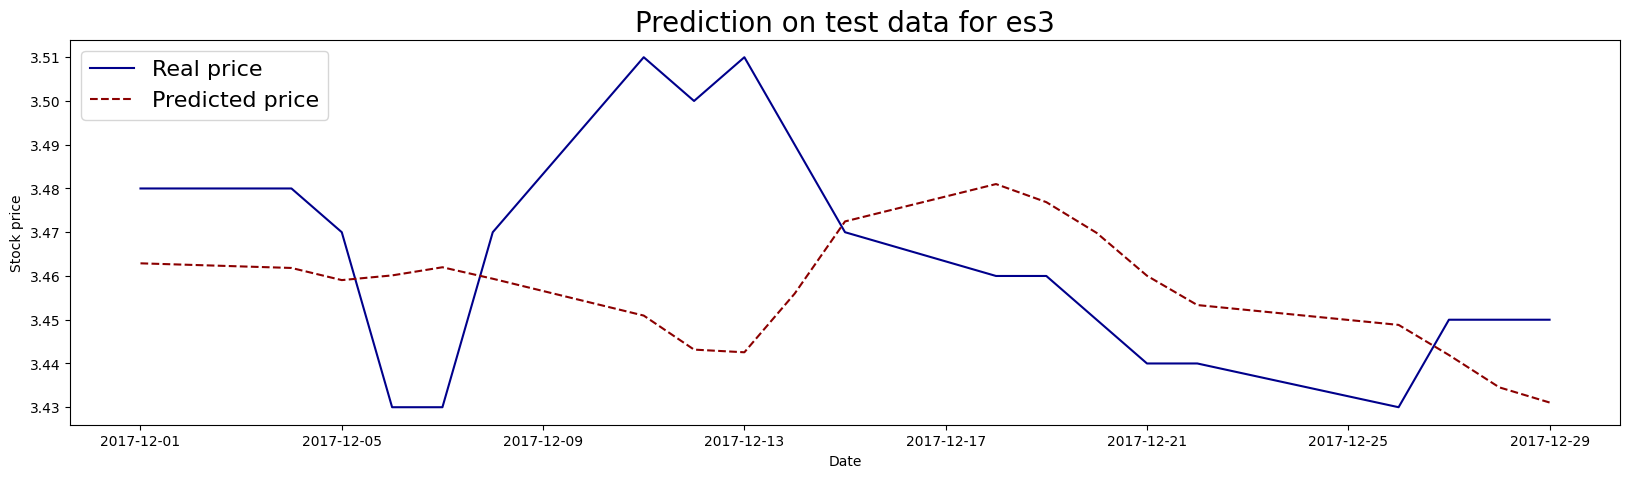

In [66]:
predicted_test_data = model.eval_op(test_generator, X_test)
model.plot_test_data(y_test, predicted_test_data,index_test, output_dim, stock_name)

### MODEL WITHOUT SENTIMENT ANALYSIS

--> Restart Kernel and Load Library, run Build Model Section before Jump straight to this section

In [9]:
learning_rate = 5e-4
epochs = 500
tf.random.set_seed(42)

g_optimizer_wo = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer_wo = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator_wo = model.make_generator_model(X_train_wo.shape[1], output_dim, X_train_wo.shape[2])
discriminator_wo = model.make_discriminator_model(X_train_wo.shape[1])

  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 10%|████▏                                     | 50/500 [01:07<08:15,  1.10s/it]

epoch 50 discriminator_loss 1.3722502 generator_loss 0.7084846


 20%|████████▏                                | 100/500 [02:00<07:06,  1.07s/it]

epoch 100 discriminator_loss 1.4161357 generator_loss 0.6885473


 30%|████████████▎                            | 150/500 [02:50<06:06,  1.05s/it]

epoch 150 discriminator_loss 1.3915927 generator_loss 0.69194156


 40%|████████████████▍                        | 200/500 [03:40<05:17,  1.06s/it]

epoch 200 discriminator_loss 1.3878174 generator_loss 0.6917484


 50%|████████████████████▌                    | 250/500 [04:35<04:42,  1.13s/it]

epoch 250 discriminator_loss 1.3860347 generator_loss 0.6940212


 60%|████████████████████████▌                | 300/500 [05:28<03:41,  1.11s/it]

epoch 300 discriminator_loss 1.3890347 generator_loss 0.69024867


 70%|████████████████████████████▋            | 350/500 [06:22<02:50,  1.14s/it]

epoch 350 discriminator_loss 1.3887184 generator_loss 0.69069815


 80%|████████████████████████████████▊        | 400/500 [07:17<01:51,  1.11s/it]

epoch 400 discriminator_loss 1.3864399 generator_loss 0.69237596


 90%|████████████████████████████████████▉    | 450/500 [08:13<00:57,  1.15s/it]

epoch 450 discriminator_loss 1.3854456 generator_loss 0.6948671


100%|█████████████████████████████████████████| 500/500 [09:09<00:00,  1.10s/it]

epoch 500 discriminator_loss 1.3869725 generator_loss 0.6947887


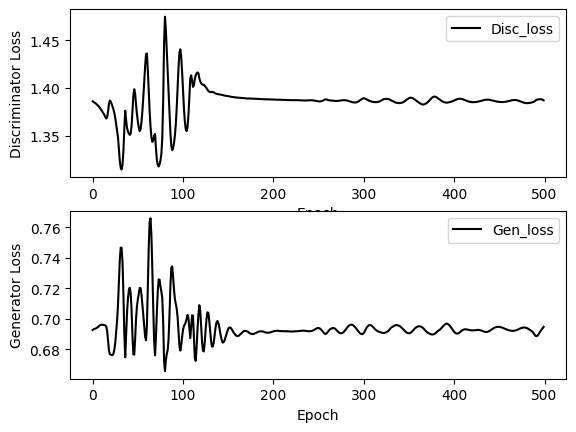

In [10]:
stock_name = 'es3_without'
predicted_price_wo, real_price_wo, RMSPE_wo = model.train(stock_name, X_train_wo, y_train_wo, yc_train_wo, epochs, generator_wo, discriminator_wo, g_optimizer_wo, d_optimizer_wo)

In [11]:
test_generator_wo = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.keras', compile=False)

Test RMSE:  0.07016891096677116


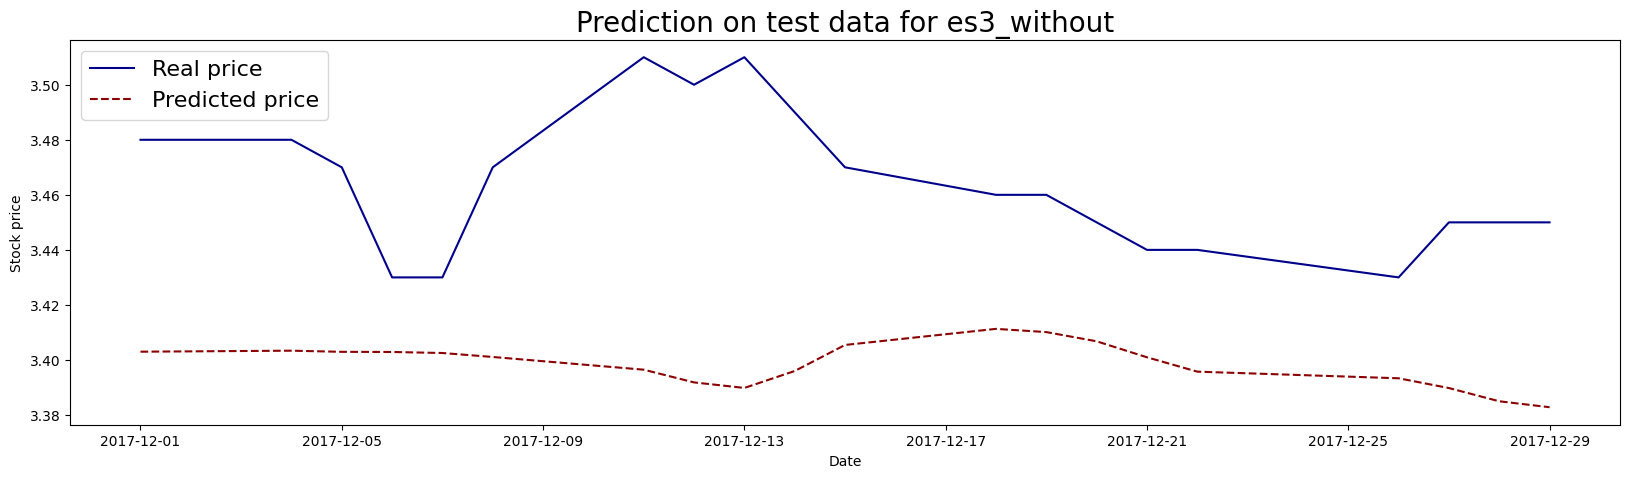

In [12]:
predicted_test_data_wo = model.eval_op(test_generator_wo, X_test_wo)
model.plot_test_data(y_test_wo, predicted_test_data_wo,index_test_wo,output_dim, stock_name)